<img style="float:left" width="70%" src="pics/escudo_COLOR_1L_DCHA.png">
<img style="float:right" width="15%" src="pics/PythonLogo.svg">
<br style="clear:both;">

<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px;">Histogramas</h2>


## PARTE I: Procesamiento *global* vs *local* 

## Docente

#### Autor: Pedro Latorre Carmona

## Alumno: Pablo Fernández Gumiel

Curso 2025-2026

Versión 1.0

In [ ]:
# Importaciones necesarias

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, util
import warnings
import math

Dimensiones de la imagen en grises: (392, 655)
Rango de valores: [0, 249]


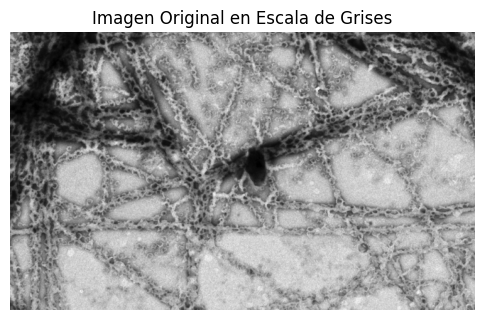

In [24]:
# Bloque de código para mostrar la imagen original

image_rgb = io.imread('GreyScaleMicroscopyImage.png')
# Convertir a escala de grises (float en [0, 1]) y luego a 8 bits (uint8 en [0, 255])
image_gray_8bit = util.img_as_ubyte(color.rgb2gray(image_rgb))

print(f"Dimensiones de la imagen en grises: {image_gray_8bit.shape}")
print(f"Rango de valores: [{np.min(image_gray_8bit)}, {np.max(image_gray_8bit)}]")

# Mostramos la imagen de partida
plt.figure(figsize=(6, 6))
plt.imshow(image_gray_8bit, cmap='gray', vmin=0, vmax=255)
plt.title('Imagen Original en Escala de Grises')
plt.axis('off')
plt.show()

### 1.1. Diagnóstico: El Histograma Original

* **¿Qué va a mostrar el código?** La celda de código a continuación calculará y mostrará el **histograma** de la imagen que acabamos de cargar.

* **¿Qué es un Histograma?** Un histograma es un gráfico de barras que actúa como un "censo" de los píxeles de una imagen. Es nuestra herramienta de diagnóstico principal.
    * El **eje X** representa el nivel de gris (desde 0, que es negro puro, hasta 255, que es blanco puro).
    * El **eje Y** (la altura de cada barra) representa *cuántos píxeles* en la imagen tienen exactamente ese nivel de gris.

* **¿Qué nos dirá este gráfico?** Al ejecutarlo, veremos que la mayoría de las barras altas están "amontonadas" en una zona estrecha en el centro del gráfico. Esto significa que casi todos los píxeles tienen tonos de gris muy similares, y apenas hay píxeles muy oscuros (cerca de 0) o muy claros (cerca de 255). Esta es la definición visual del **bajo contraste**.

* **Nuestro Objetivo:** Usaremos esta información para definir una *transformación* que "estire" este montón de píxeles a lo largo de todo el eje X, desde 0 hasta 255.

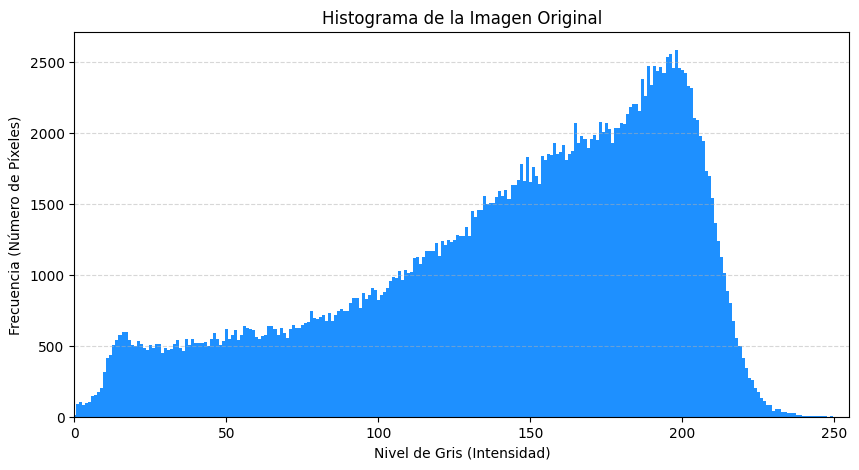

In [2]:
# --- Objetivo 1: Analizar el Histograma ---

# Calcular el histograma usando np.histogram
# .ravel() convierte la matriz 2D en un array 1D para el cálculo
hist, bins = np.histogram(image_gray_8bit.ravel(), bins=256, range=[0, 256])

# Visualizar el histograma
plt.figure(figsize=(10, 5))
plt.bar(bins[:-1], hist, width=1, color='dodgerblue')
plt.title('Histograma de la Imagen Original')
plt.xlabel('Nivel de Gris (Intensidad)')
plt.ylabel('Frecuencia (Número de Píxeles)')
plt.xlim([0, 255])
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.show()

### 1.2. Conclusiones del Histograma mostrado

Como se ha comentado antes de ejecutar el código la imagen que vemos arriba es el **Histograma** de nuestra imagen

* **¿Qué vemos aquí?** Vemos que casi todos los píxeles de nuestra imagen están "amontonados" en una zona estrecha en el centro del gráfico (p.ej., entre 50 y 150). Apenas hay píxeles en las zonas oscuras (cerca de 0) o en las zonas claras (cerca de 255).
* **¿Qué significa esto?** Esto se traduce en una imagen de **bajo contraste**. Los detalles son difíciles de ver porque las partes que nos interesan (quizás el núcleo de una célula y el citoplasma) tienen valores de gris muy similares.

### 2.1. Herramienta Global: ¿Qué es una Transformación Lineal por Partes?

Ahora vamos a construir nuestra primera herramienta.

* **¿Qué es una Transformación Lineal por Partes?** Es el método que hemos programado en nuestra función `aplicar_transformacion_lineal`. Es una forma sencilla y potente de crear una "regla de conversión" para los píxeles. En lugar de usar una fórmula matemática compleja (como una curva), simplemente definimos unos pocos **puntos de control** y el programa los **conecta con líneas rectas** (lineal) para crear una regla que funciona por segmentos (por partes).

* **¿Cómo funciona?** Nosotros le damos al programa un conjunto de puntos `(r, s)`:
    * **`r` (entrada):** Es el nivel de gris original que queremos modificar.
    * **`s` (salida):** Es el *nuevo* nivel de gris al que `r` se convertirá.
    * *Por ejemplo: (r=80, s=20) significa "toma todos los píxeles que valen 80 y conviértelos en 20".*

* **¿Qué va a hacer el código?** La celda siguiente:
    1.  Te **preguntará** por consola cuántos puntos de control `(r, s)` quieres definir.
    2.  Llamará a nuestra función `aplicar_transformacion_lineal`.
    3.  La función **aplicará** esta *única regla* a *toda la imagen* (por eso se llama "global").
    4.  Finalmente, **mostrará** la nueva imagen transformada, la gráfica con las rectas generadas en funcion de los puntos y su nuevo histograma, para que puedas ver el efecto de los puntos que elegiste.

In [ ]:
# --- Objetivo 2: Transformación Global ---

# En este bloque de código defino la funcion base que voy a utilizar para la transformación lineal tanto global como por partes

def aplicar_transformacion_lineal(segmento, points, title_for_plot=""):
    """
    Aplica una transformación lineal por partes a un segmento (bloque) de imagen.

    Parámetros:
    ----------
    segmento : np.ndarray
        La matriz 2D (imagen/bloque) a la que se aplicará la transformación.
    points : list of tuples
        Una lista de tuplas (r, s), donde 'r' es el valor de entrada y 's' el de salida.
    title_for_plot : str, opcional
        Si se proporciona, genera una gráfica de la función de transformación (LUT)
        con este título.

    Retorna:
    -------
    np.ndarray
        El segmento transformado.
    """
    
    # Si no se proporcionan puntos, aplicar una transformación identidad
    if not points:
        points = [(0, 0), (255, 255)]

    # Ordenar puntos por el valor 'r'
    sorted_points = sorted(list(points), key=lambda x: x[0])
    
    # Extrapolar desde el primer y último punto
    r_first, s_first = sorted_points[0]
    r_last, s_last = sorted_points[-1]
    
    transformed_points = [(0, s_first)] + sorted_points
    if r_last < 255:
        transformed_points.append((255, s_last))
    
    lut = np.zeros(256, dtype=np.uint8)
    
    for i in range(len(transformed_points) - 1):
        r1, s1 = transformed_points[i]
        r2, s2 = transformed_points[i+1]
        
        if r2 - r1 == 0:
            lut[r1:r2+1] = np.clip(s1, 0, 255)
            continue
            
        m = (s2 - s1) / (r2 - r1)
        
        for r_val in range(r1, r2 + 1):
            s_val = s1 + m * (r_val - r1)
            lut[r_val] = np.clip(s_val, 0, 255)
            
    if title_for_plot:
        # Extraer solo los puntos que el usuario definió
        original_r = [p[0] for p in points]
        original_s = [p[1] for p in points]
        
        plt.figure(figsize=(7, 5))
        plt.plot(range(256), lut, 'b-', label='Transformación')
        plt.plot(original_r, original_s, 'ro', label='Puntos Definidos (r,s)')
        
        plt.title(title_for_plot)
        plt.xlabel('Nivel de Gris de Entrada (r)')
        plt.ylabel('Nivel de Gris de Salida (s)')
        plt.xlim([0, 255])
        plt.ylim([0, 255])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
            
    return lut[segmento]


--- Definición de la Transformación Global ---
Introduce los puntos (r, s) para la transformación.
La transformación se extrapolará desde el primer y último punto que definas.

Has seleccionado los siguientes 4 puntos:
  Punto 1: (r=0, s=0)
  Punto 2: (r=100, s=50)
  Punto 3: (r=200, s=250)
  Punto 4: (r=255, s=255)


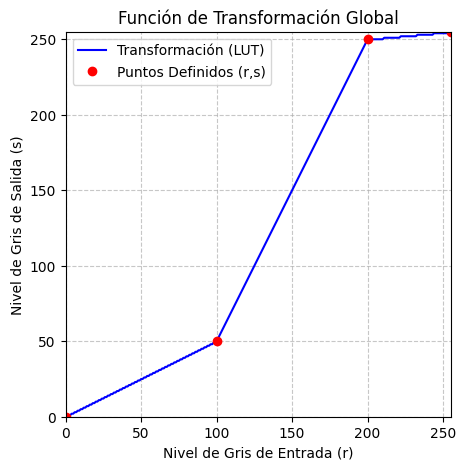

Mostrando resultados de la transformación global...


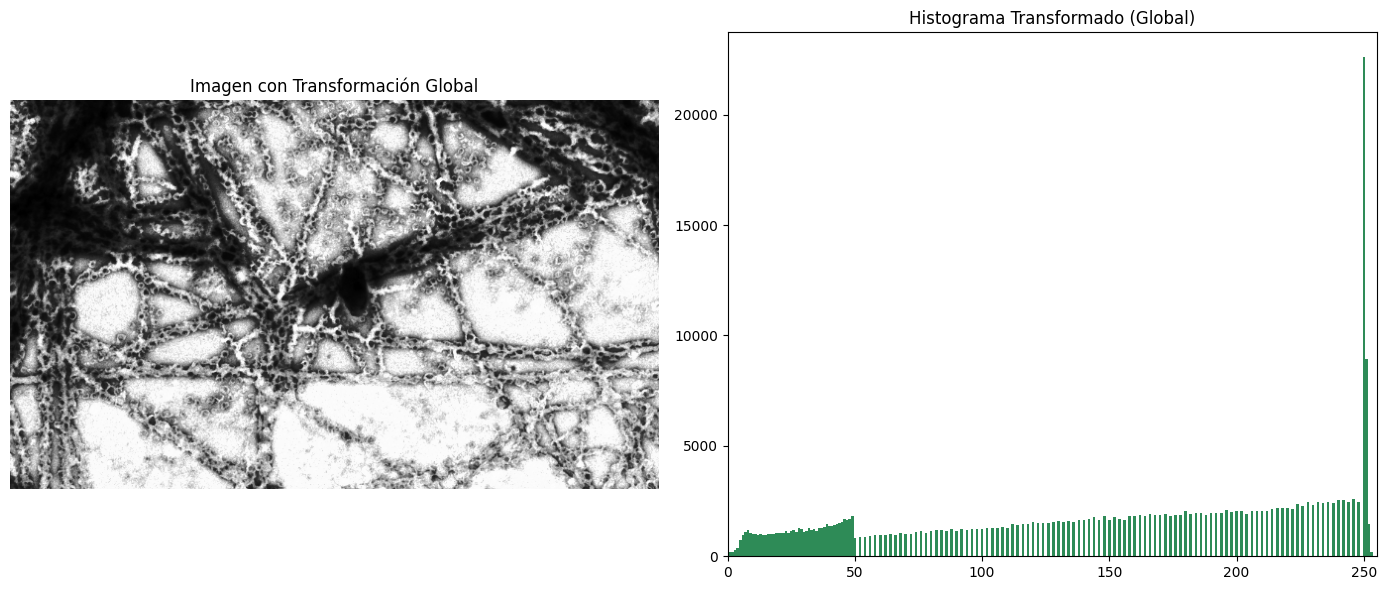

In [ ]:
#Ejecutar este bloque para la trnsformación global

print("\n--- Definición de la Transformación Global ---")
print("Introduce los puntos (r, s) para la transformación.")
print("La transformación se extrapolará desde el primer y último punto que definas.")

user_points_global = []
try:
    num_points_global = int(input("Introduce el número de puntos que deseas definir: "))
    for i in range(num_points_global):
        r = int(input(f"  Introduce r{i+1} (0-255): "))
        s = int(input(f"  Introduce s{i+1} (0-255): "))
        user_points_global.append((r, s))
except ValueError:
    print("Entrada inválida. Se aplicará una transformación por defecto (sin cambios).")
    user_points_global = [] # La función lo tratará como identidad


# Confirmar al usuario los puntos que ha seleccionado
if user_points_global:
    print(f"\nHas seleccionado los siguientes {len(user_points_global)} puntos:")
    # Imprimimos los puntos ordenados por 'r' para mayor claridad
    for i, (r, s) in enumerate(sorted(user_points_global, key=lambda x: x[0])):
        print(f"  Punto {i+1}: (r={r}, s={s})")
else:
    print("\nNo se seleccionaron puntos, aplicando transformación por defecto.")


# Aplicar la transformación global y generar la gráfica de la LUT
image_global_enhanced = aplicar_transformacion_lineal(
    image_gray_8bit, 
    user_points_global, 
    title_for_plot="Función de Transformación Global"
)

# --- Visualización de resultados globales ---
print("Mostrando resultados de la transformación global...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Imagen transformada
axes[0].imshow(image_global_enhanced, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Imagen con Transformación Global')
axes[0].axis('off')

# Histograma de la imagen transformada
hist_global, _ = np.histogram(image_global_enhanced.ravel(), bins=256, range=[0, 256])
axes[1].bar(range(256), hist_global, width=1, color='seagreen')
axes[1].set_title('Histograma Transformado (Global)')
axes[1].set_xlim([0, 255])

plt.tight_layout()
plt.show()

### 2.2. Análisis del Resultado Global y Estrategia de Puntos

Como hemos comentado antes se ha generado una nueva imagen transformada en función de los puntos que hemos seleccionado, tambien se ha generado un gráfico con las rectas que nos permite entender un poco mas como se ha llevado a cabo el proceso. 

El histograma en estos casos de transformación no es tan util pero he decidido mostrarlo para añadir más información.

#### Estrategias para Seleccionar Puntos (El "Por Qué")

El resultado de la transformación (sea "bueno" o "malo") depende enteramente de los puntos que elegimos. La clave es usarlos en base al histograma que vimos antes.

* **Para Aumentar el Contraste (Estirar):**
    * **Acción:** Creamos una **pendiente pronunciada** en la zona de interés.
    * **Ejemplo:** Si el histograma nos dice que todo está entre `r=50` y `r=150`, podemos introducir dos puntos: `(r=50, s=0)` y `(r=150, s=255)`.
    * **Efecto:** El rango de entrada `[50, 150]` (que solo tiene 100 niveles) se *estira* para cubrir todo el rango de salida `[0, 255]`. Los píxeles con valores `r=50` y `r=51` (casi idénticos) se convierten en `s=0` y `s=2` (claramente distintos). Así es como los detalles "ocultos" se hacen visibles.

* **Para Reducir el Contraste (Comprimir):**
    * **Acción:** Creamos una **pendiente suave o plana**.
    * **Ejemplo:** Si un rango de `r=[200, 230]` es un reflejo brillante sin interés, podemos introducir: `(r=200, s=210)` y `(r=230, s=215)`.
    * **Efecto:** El rango de entrada de 30 niveles se *comprime* en un rango de salida de solo 5 niveles. Esto reduce la importancia de esa zona.

* **Para Invertir (Negativo):**
    * **Acción:** Creamos una **pendiente negativa**.
    * **Ejemplo:** `(r=0, s=255)` y `(r=255, s=0)`.
    * **Efecto:** Los píxeles oscuros se vuelven claros y los claros oscuros.

**Importante:** Esta herramienta global es como un "rodillo de pintura". Es potente, pero no tiene precisión. Si una zona de la imagen *ya estaba bien* y otra *estaba mal*, el rodillo pintará sobre ambas por igual, pudiendo empeorar la que estaba bien.

### 3.1. Herramienta Local: Mayor Precisión

La herramienta global tiene una limitación clara: ¿qué pasa si la esquina superior izquierda de la imagen es muy oscura y la inferior derecha es muy brillante? Una sola regla global no puede arreglar ambas.

La solución es **dividir y vencer**.

* **¿Qué va a hacer el código?** La siguiente celda es la más compleja. Hará lo siguiente:
    1.  **Dividirá** la imagen en 4 cuadrantes (una cuadrícula 2x2).
    2.  **Iterará (bucle) 4 veces**, una por cada cuadrante.
    3.  **En cada iteración:**
        * Mostrará el **segmento** de la imagen y su **histograma local** (que será distinto al de los otros bloques).
        * Pausará la ejecución y te **pedirá puntos `(r, s)`** solo para ese bloque.
        * Llamará a la *misma* función `aplicar_transformacion_lineal`, pero esta vez solo sobre ese trozo.
    4.  Al final, **reconstruirá** la imagen final a partir de los 4 trozos procesados individualmente.

Esto nos permite, por ejemplo:
* **En el Bloque 1 (oscuro):** Aplicar un estiramiento agresivo en los tonos bajos (ej. `(r=20, s=0)` y `(r=80, s=255)`).
* **En el Bloque 4 (brillante):** Aplicar un estiramiento diferente en los tonos altos (ej. `(r=170, s=0)` y `(r=240, s=255)`).

Esto es, en esencia, aplicar 4 transformaciones "mini", cada una perfectamente adaptada a las necesidades de su región. La estrategia de puntos (estirar, comprimir) es la misma que antes, pero ahora la aplicas con mayor precisión solo donde se necesita.

**Nota**: Aumentaría la precisión aún mas si permitiese dividir la imagen en el numero de segmentos que quiera la persona que este utilizando la herramienta, pero en este caso solo he permitido dividir de manera automática la imagen en 4 segmentos iguales.


--- INICIO DE LA MEJORA LOCAL INTERACTIVA (2x2 CUADRÍCULA) ---
La imagen se dividirá en 2x2 = 4 bloques.

Observación de ventana para el Bloque 1. Ciérrala para continuar.


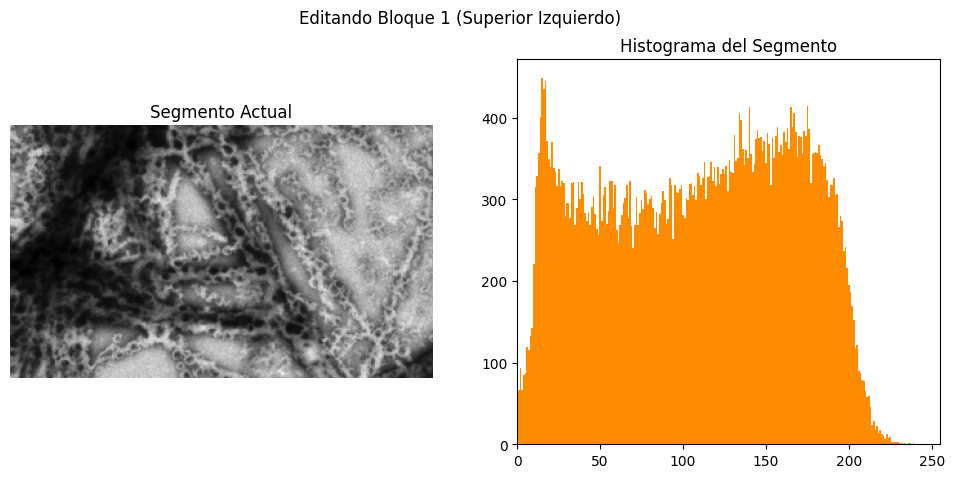

--- Definiendo transformación para el Bloque 1 (Superior Izquierdo) ---
Entrada inválida. No se aplicarán cambios a este bloque.


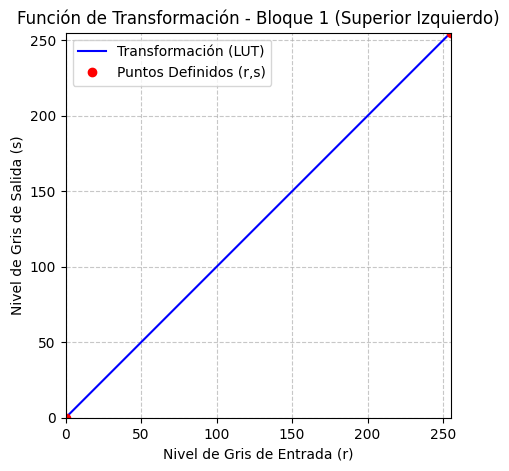

 Bloque 1 procesado.

Observación de ventana para el Bloque 2. Ciérrala para continuar.


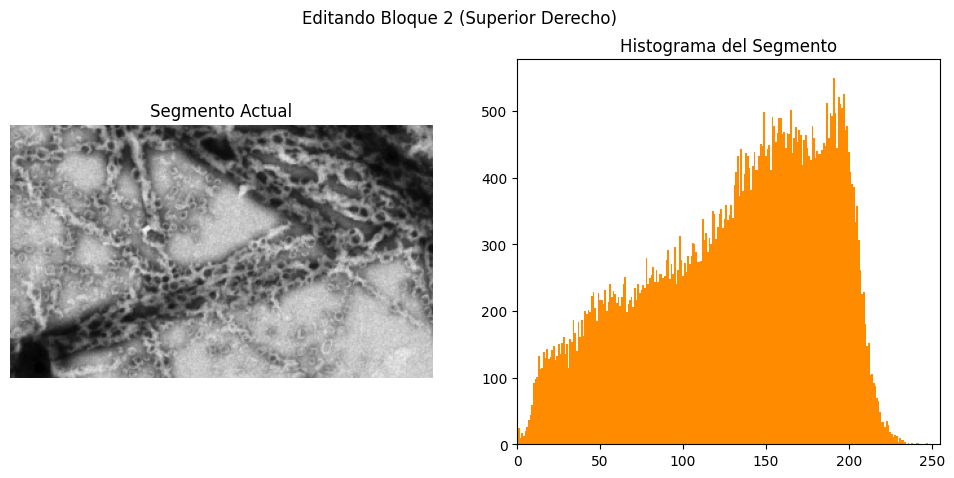

--- Definiendo transformación para el Bloque 2 (Superior Derecho) ---
Entrada inválida. No se aplicarán cambios a este bloque.


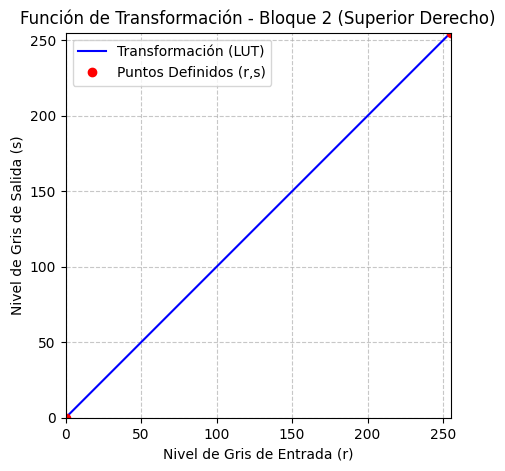

 Bloque 2 procesado.

Observación de ventana para el Bloque 3. Ciérrala para continuar.


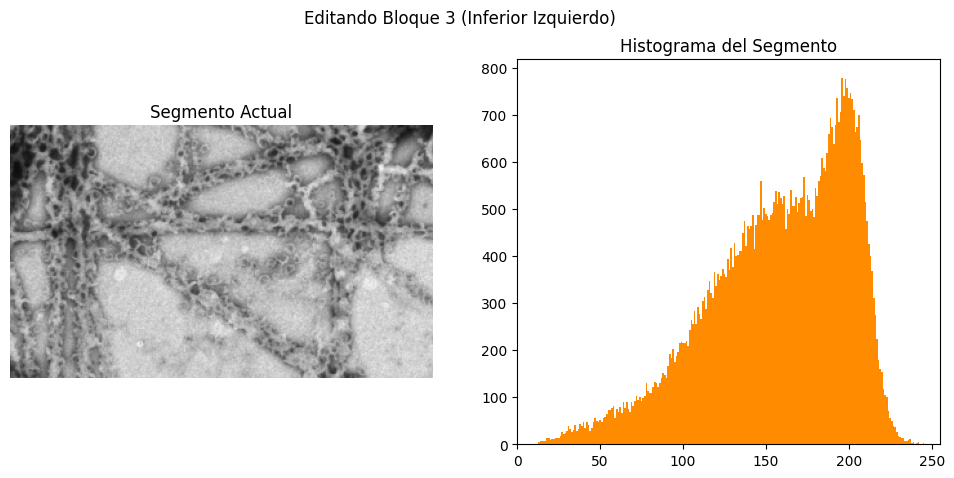

--- Definiendo transformación para el Bloque 3 (Inferior Izquierdo) ---
Entrada inválida. No se aplicarán cambios a este bloque.


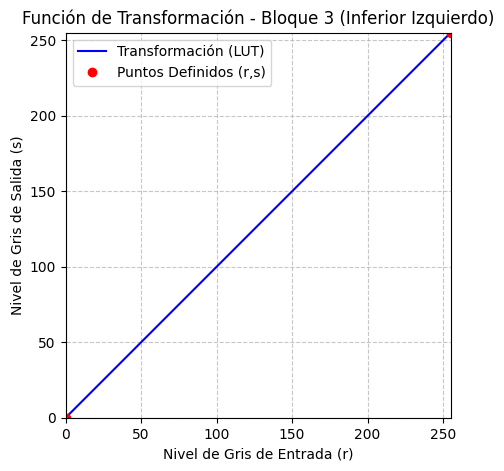

 Bloque 3 procesado.

Observación de ventana para el Bloque 4. Ciérrala para continuar.


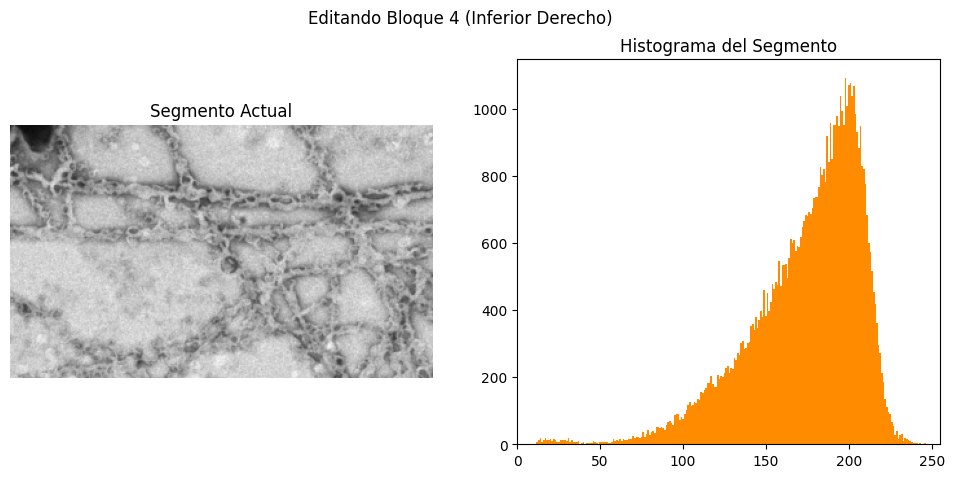

--- Definiendo transformación para el Bloque 4 (Inferior Derecho) ---
Entrada inválida. No se aplicarán cambios a este bloque.


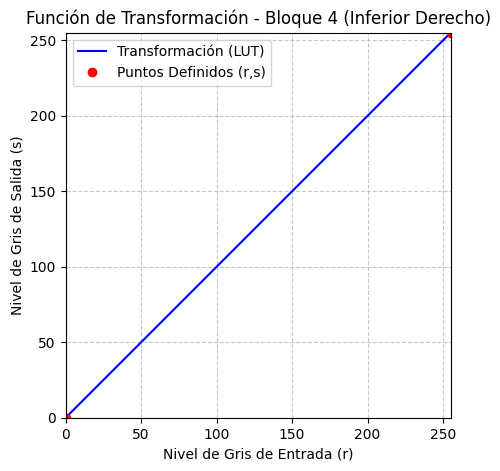

 Bloque 4 procesado.

--- PROCESO INTERACTIVO COMPLETADO ---


In [22]:
# --- Proceso Interactivo de Mejora Local (2x2 cuadrícula) ---

h, w = image_gray_8bit.shape
image_local_interactive = np.zeros_like(image_gray_8bit)

num_div_h = 2
num_div_w = 2

block_h = math.ceil(h / num_div_h)
block_w = math.ceil(w / num_div_w)
block_size = (block_h, block_w)

print(f"\n--- INICIO DE LA MEJORA LOCAL INTERACTIVA (2x2 CUADRÍCULA) ---")
print(f"La imagen se dividirá en {num_div_h}x{num_div_w} = 4 bloques.")

block_count = 0
block_map = {0: "Superior Izquierdo", 1: "Superior Derecho", 2: "Inferior Izquierdo", 3: "Inferior Derecho"}

for r_idx in range(num_div_h):
    for c_idx in range(num_div_w):
        block_count += 1
        
        r_start = r_idx * block_size[0]
        c_start = c_idx * block_size[1]
        r_end = min(r_start + block_size[0], h)
        c_end = min(c_start + block_size[1], w)
        
        bloque_actual = image_gray_8bit[r_start:r_end, c_start:c_end]
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            block_name = block_map.get(block_count-1, 'Desconocido')
            fig.suptitle(f"Editando Bloque {block_count} ({block_name})")
            
            axes[0].imshow(bloque_actual, cmap='gray', vmin=0, vmax=255)
            axes[0].set_title('Segmento Actual')
            axes[0].axis('off')
            
            hist_bloque, _ = np.histogram(bloque_actual.ravel(), bins=256, range=[0, 256])
            axes[1].bar(range(256), hist_bloque, width=1, color='darkorange')
            axes[1].set_title('Histograma del Segmento')
            axes[1].set_xlim([0, 255])
            
            print(f"\nObservación de ventana para el Bloque {block_count}. Ciérrala para continuar.")
            # block=True es crucial para pausar la ejecución del notebook
            plt.show(block=True)

        print(f"--- Definiendo transformación para el Bloque {block_count} ({block_name}) ---")
        user_points_local = []
        try:
            num_points_local = int(input("Introduce el número de puntos para la transformación: "))
            for i in range(num_points_local):
                r = int(input(f"  Introduce r{i+1} (0-255): "))
                s = int(input(f"  Introduce s{i+1} (0-255): "))
                user_points_local.append((r, s))
        except ValueError:
            print("Entrada inválida. No se aplicarán cambios a este bloque.")
        
        plot_title = f"Función de Transformación - Bloque {block_count} ({block_name})"
        bloque_transformado = aplicar_transformacion_lineal(
            bloque_actual, 
            user_points_local, 
            title_for_plot=plot_title
        )
        
        image_local_interactive[r_start:r_end, c_start:c_end] = bloque_transformado
        print(f" Bloque {block_count} procesado.")

print("\n--- PROCESO INTERACTIVO COMPLETADO ---")

### 3.2. Conclusiones de lo mostrado en la herramienta local

**Importante**: Como vemos la herramienta nos muestra las rectas resultantes aunque no muestra la imagen final formada por todos los segementos ya que esta la reserva para la comparación final de métodos. También permite no realizar ningun cambio al segmento presionando esc evitando asi cambios innecesarios o errores.

### 4.1. Comparación Final: Resultados y Conclusiones

* **¿Qué va a mostrar el código?** La celda final generará una gran figura de 2x3 (2 filas, 3 columnas) que resume todo nuestro trabajo.
    * **Fila Superior:** Mostrará las 3 imágenes una al lado de la otra: (1) Original, (2) Global, (3) Local.
    * **Fila Inferior:** Mostrará los 3 histogramas correspondientes, justo debajo de su imagen.

* **¿En qué fijarse?** Esta vista nos permite comparar no solo la "mejora" visual de las imágenes, sino también *cómo* sus histogramas (el "censo" de píxeles) han cambiado. Podremos ver cómo el histograma original "amontonado" se "estira" en el caso Global, y cómo el histograma Local (que es la suma de 4 transformaciones distintas) tiene una forma, a menudo, más compleja y distribuida.

Esta gráfica es la conclusión de la práctica, pues demuestra visualmente la diferencia de poder y precisión entre una metodología global y una local.

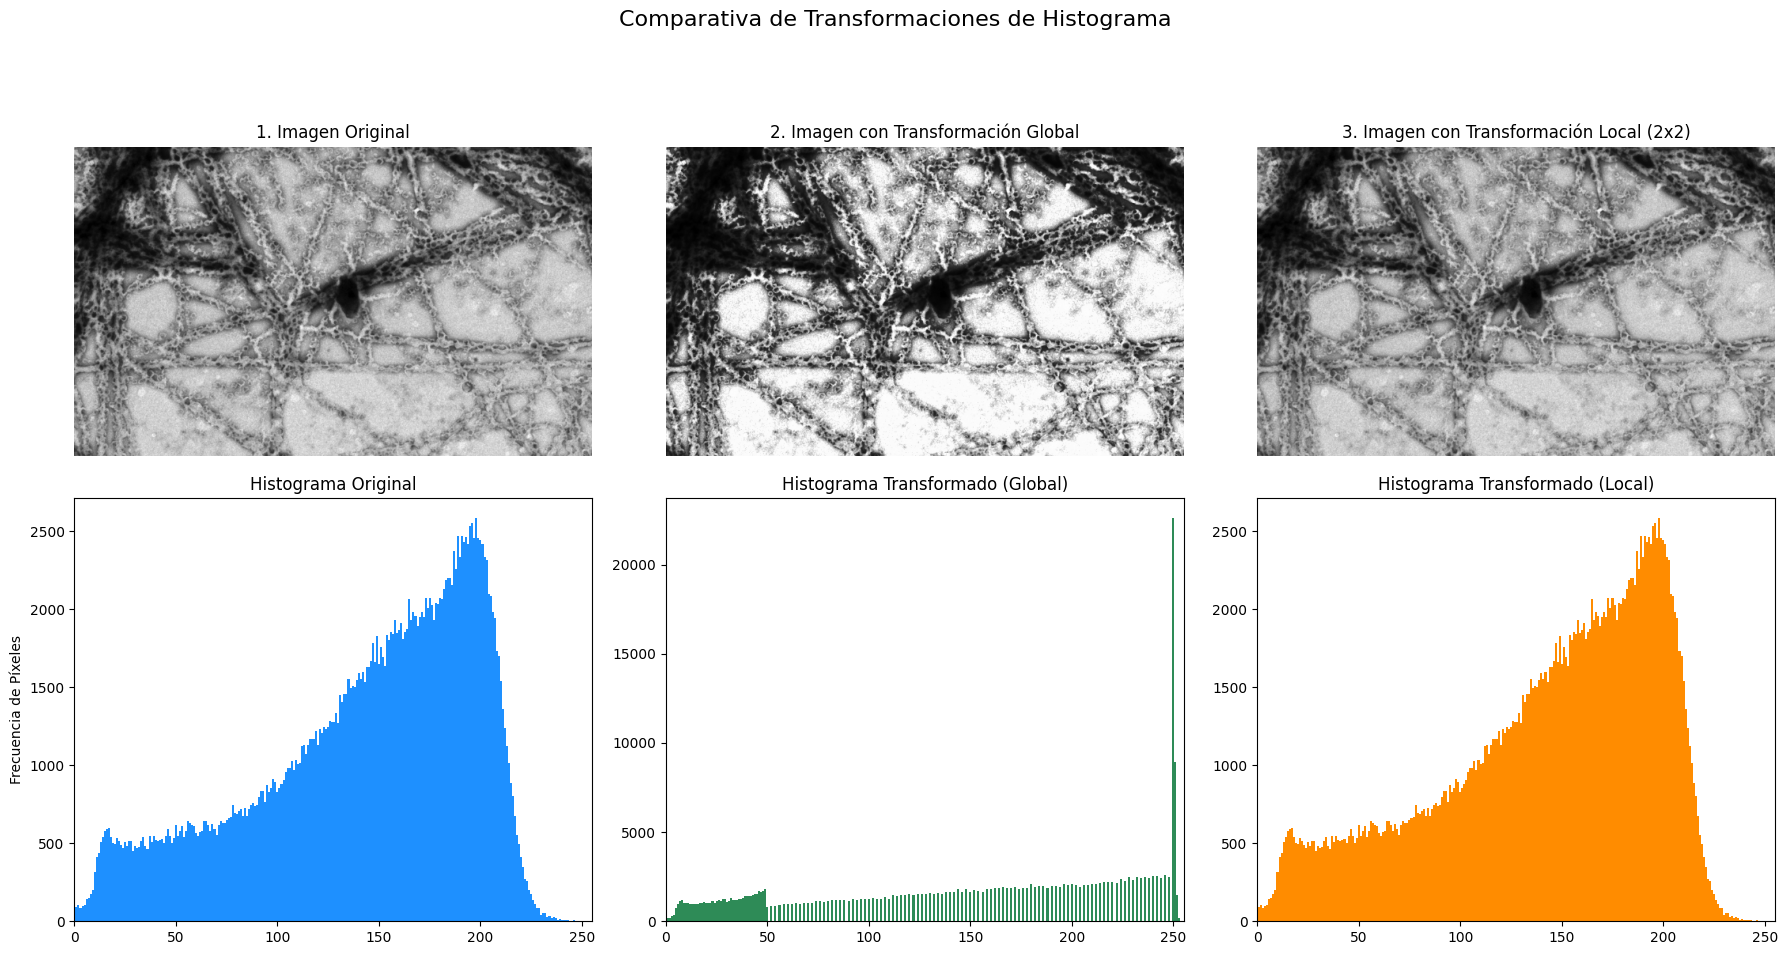

In [23]:
# --- 5. Comparación Final (Imágenes e Histogramas) ---

# Crear una cuadrícula de 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparativa de Transformaciones de Histograma', fontsize=16)

# --- Columna 1: Original ---
ax_img_orig = axes[0, 0]
ax_hist_orig = axes[1, 0]

ax_img_orig.imshow(image_gray_8bit, cmap='gray', vmin=0, vmax=255)
ax_img_orig.set_title('1. Imagen Original')
ax_img_orig.axis('off')

hist_orig, _ = np.histogram(image_gray_8bit.ravel(), bins=256, range=[0, 256])
ax_hist_orig.bar(range(256), hist_orig, width=1, color='dodgerblue')
ax_hist_orig.set_title('Histograma Original')
ax_hist_orig.set_xlim([0, 255])
ax_hist_orig.set_ylabel('Frecuencia de Píxeles')

# --- Columna 2: Global ---
ax_img_global = axes[0, 1]
ax_hist_global = axes[1, 1]

ax_img_global.imshow(image_global_enhanced, cmap='gray', vmin=0, vmax=255)
ax_img_global.set_title('2. Imagen con Transformación Global')
ax_img_global.axis('off')

hist_global, _ = np.histogram(image_global_enhanced.ravel(), bins=256, range=[0, 256])
ax_hist_global.bar(range(256), hist_global, width=1, color='seagreen')
ax_hist_global.set_title('Histograma Transformado (Global)')
ax_hist_global.set_xlim([0, 255])

# --- Columna 3: Local ---
ax_img_local = axes[0, 2]
ax_hist_local = axes[1, 2]

ax_img_local.imshow(image_local_interactive, cmap='gray', vmin=0, vmax=255)
ax_img_local.set_title('3. Imagen con Transformación Local (2x2)')
ax_img_local.axis('off')

hist_local, _ = np.histogram(image_local_interactive.ravel(), bins=256, range=[0, 256])
ax_hist_local.bar(range(256), hist_local, width=1, color='darkorange')
ax_hist_local.set_title('Histograma Transformado (Local)')
ax_hist_local.set_xlim([0, 255])

# Ajustar el espaciado para que no se solapen
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

* **Conclusión Final:**
    Hemos construido dos herramientas con diferentes filosofías:
    * La **Herramienta Global** es rápida, sencilla y muy eficaz para imágenes con iluminación uniforme.
    * La **Herramienta Local** es más lenta, compleja e interactiva, pero ofrece una potencia y precisión inigualables para imágenes con condiciones de iluminación difíciles.

    No busacábamos crear un filtro automático,si no **diseñar** unas herramientas precisas usando la transformación lineal por partes.